In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import itertools
from collections import Counter
from networkx.drawing.nx_agraph import graphviz_layout
from skbio.stats.composition import ilr
from skbio.stats.composition import clr
from skbio.stats.composition import multiplicative_replacement
import seaborn as sns
from matplotlib import rcParams
sns.set()
sns.set(font_scale=1.5)

## Load Small Sample Information DataFrame

In [7]:
allCohortInfoDF = pd.read_csv("./Files/Cohorts/SampleMappingInformation.csv").set_index("SampleName")
yourCohortCRCDF = allCohortInfoDF[allCohortInfoDF['Cohort']=='CRC'].copy()
yourCohortHealthyDF = allCohortInfoDF[allCohortInfoDF['Cohort']=='Japanese'].copy()
yourCohorts = pd.concat([yourCohortHealthyDF,yourCohortCRCDF])
yourCohorts.head()

,Cohort,Total_Reads,Mapped,Fraction_Mapped
SampleName,,,,
DRR127546,Japanese,50276444.0,23817349.0,0.473728
DRR171724,Japanese,42946188.0,26738028.0,0.622594
DRR171783,Japanese,40383932.0,26931569.0,0.666888
DRR171629,Japanese,39520812.0,28567454.0,0.722846
DRR127524,Japanese,39138650.0,18449980.0,0.471401


In [8]:
yourCohorts['Cohort'].replace("Japanese","Healthy", inplace=True)

In [9]:
yourCohorts['Total_Reads'].sum()

5778767241.0

In [10]:
yourCohorts['Mapped'].sum()

3515063526.0

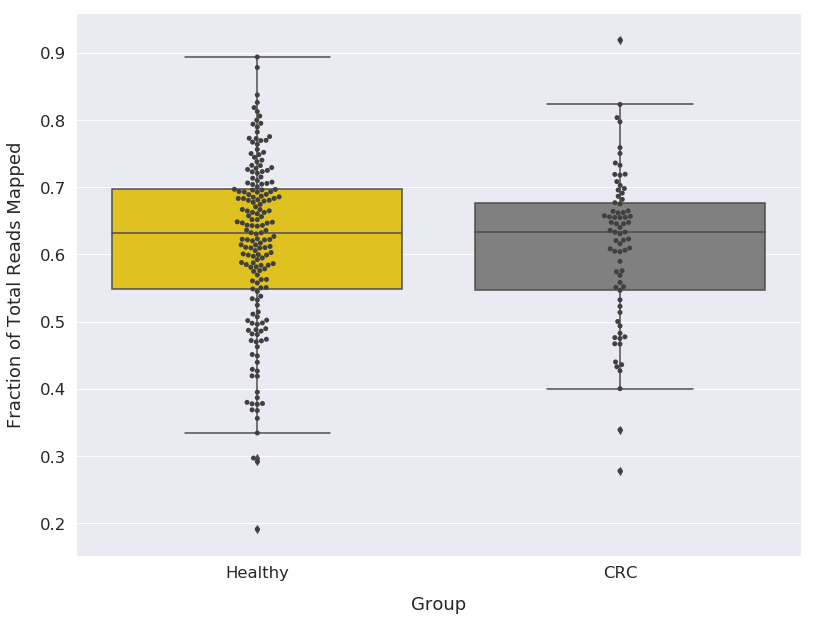

In [11]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 13,10
sns.set(font_scale=1.5)
palette ={"CRC":"grey",'Healthy':'gold'}

ax = sns.boxplot(x='Cohort', y='Fraction_Mapped', hue="Cohort", data=yourCohorts, palette=palette, dodge=False)
ax = sns.swarmplot(x="Cohort", y="Fraction_Mapped", data=yourCohorts, color=".25")

#ax.set_title('Cohort Alpha Diversity (Species Level)')
ax.set_ylabel('Fraction of Total Reads Mapped', labelpad=15)
ax.set_xlabel('Group', labelpad=15)
ax.set_xticklabels(ax.get_xticklabels())

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
ax.get_legend().remove()
#plt.savefig("ReadsMapped.pdf", bbox_inches='tight', dpi=300)
plt.show()

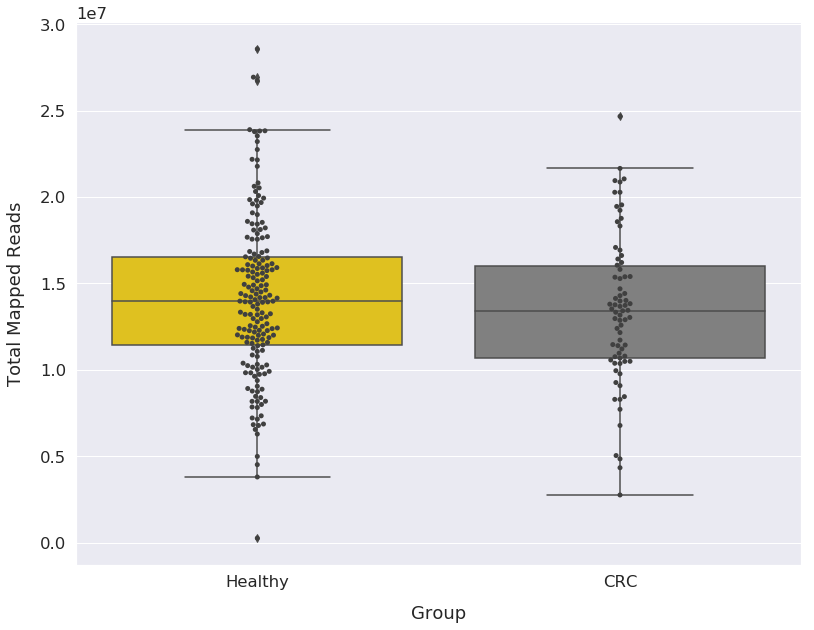

In [12]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 13,10
sns.set(font_scale=1.5)
palette ={"CRC":"grey",'Healthy':'gold'}

ax = sns.boxplot(x='Cohort', y='Mapped', hue="Cohort", data=yourCohorts, palette=palette, dodge=False)
ax = sns.swarmplot(x="Cohort", y="Mapped", data=yourCohorts, color=".25")

#ax.set_title('Cohort Alpha Diversity (Species Level)')
ax.set_ylabel('Total Mapped Reads', labelpad=15)
ax.set_xlabel('Group', labelpad=15)
ax.set_xticklabels(ax.get_xticklabels())

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
ax.get_legend().remove()
#plt.savefig("TotalReadsMapped.pdf", bbox_inches='tight', dpi=300)
plt.show()

## Average Read Length Per Sample

In [13]:
rlDictionary = {}
with open("./Files/Cohorts/countData/allCohorts.txt") as rlFile:
    for line in rlFile:
        rlDictionary[line.split(".")[0].split("_R1")[0].split("_TR")[0].split(".")[0].strip()]=line.split("\t")[1].strip()
rlDictionary

{'SRS024132': '90',
 'SRS024265': '95',
 'SRS019582': '96',
 'SRS011061': '95',
 'SRS020233': '93',
 'SRS016517': '76',
 'SRS024331': '91',
 'SRS016753': '93',
 'SRS019601': '93',
 'SRS011084': '92',
 'SRS014979': '94',
 'SRS016954': '91',
 'SRS024075': '93',
 'SRS011134': '90',
 'SRS024435': '87',
 'SRS016989': '90',
 'SRS015264': '96',
 'SRS011239': '92',
 'SRS015578': '94',
 'SRS017103': '95',
 'SRS020328': '97',
 'SRS011271': '91',
 'SRS042284': '94',
 'SRS017191': '97',
 'SRS015369': '85',
 'SRS011302': '91',
 'SRS021484': '96',
 'SRS017247': '93',
 'SRS015431': '83',
 'SRS011405': '94',
 'SRS020869': '92',
 'SRS011452': '95',
 'SRS022609': '88',
 'SRS017307': '96',
 'SRS022137': '88',
 'SRS011529': '92',
 'SRS024388': '93',
 'SRS017433': '95',
 'SRS015663': '96',
 'SRS011586': '90',
 'SRS015794': '93',
 'SRS017521': '93',
 'SRS021948': '96',
 'SRS012273': '90',
 'SRS043701': '92',
 'SRS017701': '92',
 'SRS045528': '92',
 'SRS017821': '90',
 'SRS022071': '96',
 'SRS012902': '94',


In [14]:
paper2Dictionary = {}
for x,y in rlDictionary.items():
    if x in yourCohorts.index:
        paper2Dictionary[x] = y
        
print(len(paper2Dictionary))

252


## Look at Meta Data

In [15]:
CRCMetaDF =pd.read_csv("./Files/Cohorts/Japanese_CRC_Cohort/CRC_Cancer_MetaData.txt")
CRCMetaDF.set_index("SampleName", inplace=True)
CRCMetaDF['Cohort']='CRC'
HealthyMetaDF =pd.read_csv("./Files/Cohorts/Japanese_CRC_Cohort/HealthyJapanese_metadata.csv")
HealthyMetaDF.set_index("SampleName", inplace=True)
HealthyMetaDF['Cohort']='Healthy'
allMetaData = pd.concat([HealthyMetaDF,CRCMetaDF])
allMetaData['Gender'].replace("F","Female", inplace=True)
allMetaData['Gender'].replace("M",'Male', inplace=True)
allMetaDataDF = allMetaData.loc[list(yourCohorts.index)].copy()
allMetaDataDF['Stage'].replace("Ivb",'IVB', inplace=True)
allMetaDataDF['Stage'].replace("Iva",'IVA', inplace=True)
allMetaDataDF['Stage'].replace("Ivb",'IVB', inplace=True)
allMetaDataDF['Stage'].replace("IIIA",'III', inplace=True)
allMetaDataDF['Stage'].replace("IIIB",'III', inplace=True)
allMetaDataDF['Stage'].replace("IIIC",'III', inplace=True)
allMetaDataDF['Stage'].replace("IVB",'IV', inplace=True)
allMetaDataDF['Stage'].replace("IVA",'IV', inplace=True)
allMetaDataDF['Tumor location'].replace("Rectum and Left colon",'Left colon and Rectum', inplace=True)
print(len(allMetaDataDF))
allMetaDataDF.head()

252


,Subject_ID,Group,Stage,Age,Gender,BMI,Brinkman Index,Alcohol,Tumor location,Cohort
SampleName,,,,,,,,,,
DRR127546,10350,Healthy,-,67,Female,26.04166667,0,0,-,Healthy
DRR171724,10219,Healthy,-,68,Male,21.383942,1290,0,-,Healthy
DRR171783,10258,Healthy,-,42,Male,33.14,0,0,-,Healthy
DRR171629,11495,Healthy,-,71,Female,26.6349583828775,108,379.95,-,Healthy
DRR127524,10207,Healthy,-,73,Male,25.81663021,960,549.9,-,Healthy


In [16]:
allMetaDataDF.to_csv("./Files/Cohorts/Japanese_CRC_Cohort/metaData_fixed.csv")

In [17]:
allMetaDataDF[allMetaDataDF['Cohort']=='CRC']['Stage'].value_counts()

III    52
IV     22
Name: Stage, dtype: int64

In [18]:
allMetaDataDF[allMetaDataDF['Cohort']=='CRC']['Tumor location'].value_counts()

Rectum                        36
Right colon                   20
Left colon                    13
Left colon and Rectum          3
Left colon and Right colon     2
Name: Tumor location, dtype: int64

In [20]:
allMetaDataBMI = allMetaDataDF.copy()
allMetaDataBMI['BMI'].replace("unknown",np.nan, inplace=True)
allMetaDataBMI2 = allMetaDataBMI[['BMI','Cohort']].copy()
allMetaDataBMI2['BMI'].astype(float, inplace=True)
allMetaDataBMI2.dropna(inplace=True)
allMetaDataBMI2.head()

,BMI,Cohort
SampleName,,
DRR127546,26.04166667,Healthy
DRR171724,21.383942,Healthy
DRR171783,33.14,Healthy
DRR171629,26.6349583828775,Healthy
DRR127524,25.81663021,Healthy


In [21]:
allMetaDataDF2 = allMetaDataDF[['Gender','Cohort']].copy()
tempDictionary ={"Cohort":['Healthy','Healthy','CRC','CRC'], "Gender":['Male','Female','Male','Female'], "Frequency":[len(allMetaDataDF[(allMetaDataDF['Cohort']=='Healthy') & (allMetaDataDF['Gender']=='Male')])/len(allMetaDataDF[allMetaDataDF['Cohort']=='Healthy']),len(allMetaDataDF[(allMetaDataDF['Cohort']=='Healthy') & (allMetaDataDF['Gender']=='Female')])/len(allMetaDataDF[allMetaDataDF['Cohort']=='Healthy']),len(allMetaDataDF[(allMetaDataDF['Cohort']=='CRC') & (allMetaDataDF['Gender']=='Male')])/len(allMetaDataDF[allMetaDataDF['Cohort']=='CRC']),len(allMetaDataDF[(allMetaDataDF['Cohort']=='CRC') & (allMetaDataDF['Gender']=='Female')])/len(allMetaDataDF[allMetaDataDF['Cohort']=='CRC']) ]}
tempDf = pd.DataFrame(data=tempDictionary)
tempDf.loc[:,'Frequency'] *= 100
tempDf

,Cohort,Gender,Frequency
0,Healthy,Male,56.179775
1,Healthy,Female,43.820225
2,CRC,Male,58.108108
3,CRC,Female,41.891892


In [23]:
################################################################################################################3

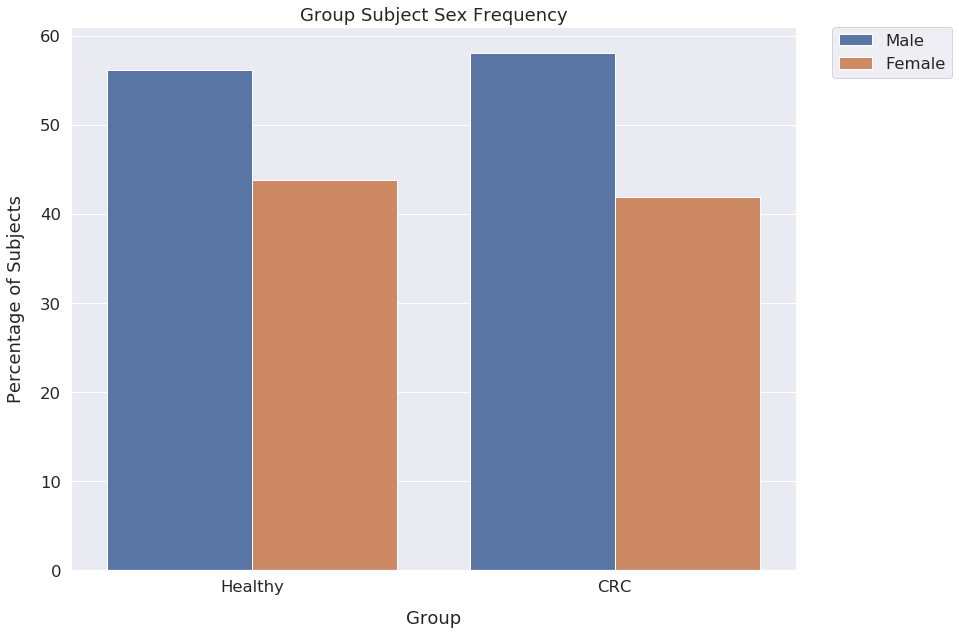

In [22]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 13,10
sns.set(font_scale=1.5)
palette ={"CRC":"C3",'Healthy':'C2'}

ax = sns.barplot(x="Cohort", y="Frequency", hue="Gender", data=tempDf)

ax.set_title('Group Subject Sex Frequency')
ax.set_ylabel('Percentage of Subjects', labelpad=15)
ax.set_xlabel('Group', labelpad=15)
ax.set_xticklabels(ax.get_xticklabels())

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
#plt.savefig("CohortSex.pdf", bbox_inches='tight', dpi=300)
plt.show()

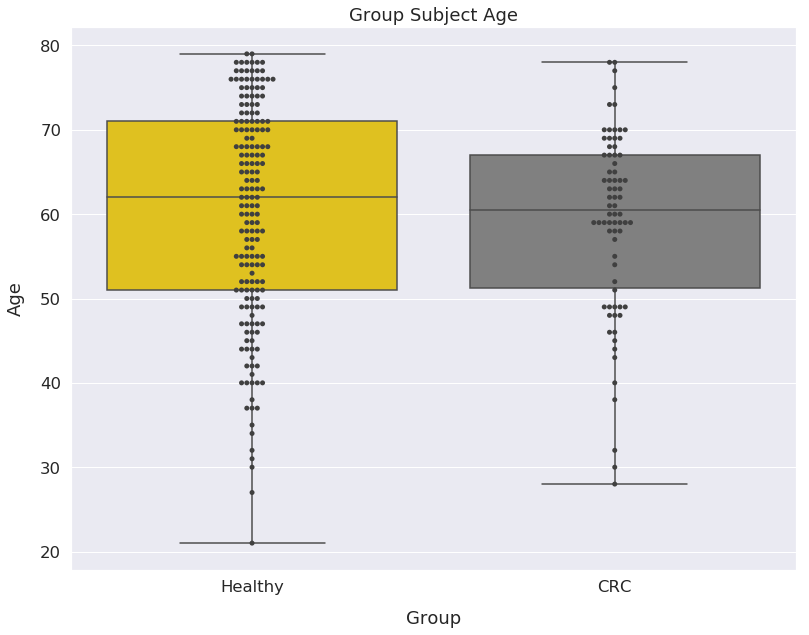

In [23]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 13,10
sns.set(font_scale=1.5)
palette ={"CRC":"grey",'Healthy':'gold'}

ax = sns.boxplot(x='Cohort', y='Age', hue="Cohort", data=allMetaDataDF, palette=palette, dodge=False)
ax = sns.swarmplot(x="Cohort", y="Age", data=allMetaDataDF, color=".25")

ax.set_title('Group Subject Age')
ax.set_ylabel('Age', labelpad=15)
ax.set_xlabel('Group', labelpad=15)
ax.set_xticklabels(ax.get_xticklabels())

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
ax.get_legend().remove()

#plt.savefig("Cohort_SubjectAge.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [26]:
allMetaDataDF[allMetaDataDF['Cohort']=='CRC']['Age'].median()

60.5